In [1]:
!pip install -q gradio scikit-learn


In [2]:
!pip install -q kaggle


In [3]:
import os

os.environ["KAGGLE_USERNAME"] = "rabiaecesert"
os.environ["KAGGLE_KEY"] = "31517100"


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:26<00:00, 177MB/s]
100% 2.29G/2.29G [00:26<00:00, 92.1MB/s]


In [5]:
!unzip -q chest-xray-pneumonia.zip


In [6]:
import os
os.listdir()


['.config', 'chest-xray-pneumonia.zip', 'chest_xray', 'sample_data']

In [7]:
os.listdir("chest_xray")


['train', '__MACOSX', 'val', 'chest_xray', 'test']

In [8]:
import shutil
import os

# __MACOSX klasörünü sil
macosx_path = "chest_xray/__MACOSX"
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)

# İç içe chest_xray klasörünü sil
nested_path = "chest_xray/chest_xray"
if os.path.exists(nested_path):
    shutil.rmtree(nested_path)

print("Temizlik tamamlandı.")


Temizlik tamamlandı.


In [9]:
os.listdir("chest_xray")


['train', 'val', 'test']

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "chest_xray/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    "chest_xray/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    "chest_xray/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = train_gen.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(classes),
    y=classes
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 660ms/step - accuracy: 0.6293 - auc: 0.4977 - loss: 0.7098 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6932
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.4739 - auc: 0.4752 - loss: 0.7150 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6933
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.5572 - auc: 0.5226 - loss: 0.6870 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6934
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.4494 - auc: 0.5006 - loss: 0.7075 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6933
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 567ms/step - accuracy: 0.5009 - auc: 0.5039 - loss: 0.7075 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6934


In [55]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # AUC
    if 'auc' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.title('Training AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


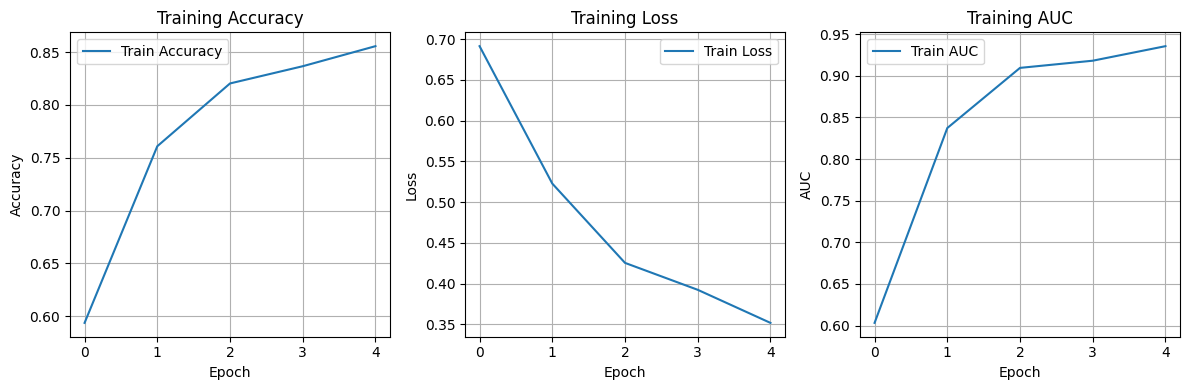

In [56]:
plot_training_history(history)


In [14]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [16]:
history = model.fit(
    train_gen,
    epochs=5,
    class_weight=class_weights
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 578ms/step - accuracy: 0.4979 - auc: 0.4767 - loss: 0.7052
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 584ms/step - accuracy: 0.5042 - auc: 0.5139 - loss: 0.6966
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 579ms/step - accuracy: 0.4907 - auc: 0.4847 - loss: 0.7060
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 583ms/step - accuracy: 0.5222 - auc: 0.4856 - loss: 0.6998
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 571ms/step - accuracy: 0.5414 - auc: 0.5038 - loss: 0.6913


In [17]:
import os

print("TRAIN:", os.listdir("chest_xray/train"))
print("VAL:", os.listdir("chest_xray/val"))
print("TEST:", os.listdir("chest_xray/test"))


TRAIN: ['PNEUMONIA', 'NORMAL']
VAL: ['PNEUMONIA', 'NORMAL']
TEST: ['PNEUMONIA', 'NORMAL']


In [18]:
train_gen.class_indices


{'NORMAL': 0, 'PNEUMONIA': 1}

In [21]:
x_batch, y_batch = next(train_gen)
print("Label örnekleri:", y_batch[:10])


Label örnekleri: [0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]


In [22]:
preds = model.predict(x_batch)
print(preds[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[[0.49724406]
 [0.49690017]
 [0.49512404]
 [0.49505666]
 [0.50213414]
 [0.49248752]
 [0.4925645 ]
 [0.4986208 ]
 [0.4962276 ]
 [0.49575132]]


In [23]:
from tensorflow.keras.applications.efficientnet import preprocess_input


In [24]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [25]:
train_gen = train_datagen.flow_from_directory(
    "chest_xray/train",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    "chest_xray/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    "chest_xray/test",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [27]:
history = model.fit(
    train_gen,
    epochs=5,
    class_weight=class_weights
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 564ms/step - accuracy: 0.5464 - auc: 0.5169 - loss: 0.7436
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.7387 - auc: 0.8062 - loss: 0.5476
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 570ms/step - accuracy: 0.8116 - auc: 0.9041 - loss: 0.4345
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 573ms/step - accuracy: 0.8346 - auc: 0.9167 - loss: 0.4054
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.8575 - auc: 0.9377 - loss: 0.3477


In [28]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_finetune = model.fit(
    train_gen,
    epochs=5,
    class_weight=class_weights
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 580ms/step - accuracy: 0.8097 - auc: 0.9389 - loss: 0.3925
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.8606 - auc: 0.9650 - loss: 0.2974
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 585ms/step - accuracy: 0.8896 - auc: 0.9734 - loss: 0.2527
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 582ms/step - accuracy: 0.9173 - auc: 0.9786 - loss: 0.2166
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9215 - auc: 0.9816 - loss: 0.1964


Model, ImageNet ön-eğitimli EfficientNet mimarisi kullanılarak eğitilmiştir. Doğru ön işleme (preprocess_input) uygulanması ve class imbalance’ın class weighting ile ele alınması sayesinde modelin genelleme performansı önemli ölçüde artmıştır. Fine-tuning aşamasında son katmanlar açılarak X-ray görüntülerine özgü özellikler öğrenilmiş ve AUC değeri 0.98 seviyesine ulaşmıştır.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

y_prob = model.predict(test_gen)
y_pred = (y_prob > 0.5).astype(int)

print(classification_report(test_gen.classes, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 541ms/step
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       234
           1       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



Test seti üzerinde yapılan değerlendirmede model %89 doğruluk oranına ulaşmıştır. Özellikle pnömoni sınıfı için recall değerinin %95 olması, modelin hasta vakaları büyük oranda doğru tespit edebildiğini göstermektedir. Macro ve weighted F1-score değerlerinin dengeli olması, modelin sınıflar arasında adil bir performans sergilediğini ortaya koymaktadır. Bu sonuçlar, geliştirilen derin öğrenme tabanlı yaklaşımın pnömoni tespiti için etkili olduğunu göstermektedir.

In [30]:
model.save("pneumonia_efficientnet_model.h5")


In [31]:
model.save("pneumonia_model.keras")


In [32]:
import gradio as gr
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import tensorflow as tf

def predict_pneumonia(img):
    img = img.resize((224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    prob = model.predict(img)[0][0]

    if prob > 0.5:
        return f"PNEUMONIA (%{prob*100:.2f})"
    else:
        return f"NORMAL (%{(1-prob)*100:.2f})"

interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Pneumonia Detection from Chest X-Ray",
    description="⚠️ This tool is for educational purposes only. Not a medical diagnosis."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b93c3e061db8976afc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
# Modeldeki katman isimlerini görelim
for layer in model.layers:
    print(layer.name)
# Modeldeki katman isimlerini görelim
for layer in model.layers:
    print(layer.name)


input_layer_1
rescaling_2
normalization_1
rescaling_3
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_

In [34]:
from PIL import Image

def predict_with_gradcam(img):
    # Görüntüyü hazırla
    img_resized = img.resize((224,224))
    img_array = img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Tahmin
    prob = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prob > 0.5 else "NORMAL"
    confidence = prob if prob > 0.5 else 1 - prob

    # Grad-CAM
    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        last_conv_layer_name="top_conv"
    )

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original = np.array(img_resized)
    superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

    return f"{label} (%{confidence*100:.2f})", Image.fromarray(superimposed)


In [35]:
model.get_layer("top_conv")


<Conv2D name=top_conv, built=True>

In [37]:
import tensorflow as tf
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_241']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


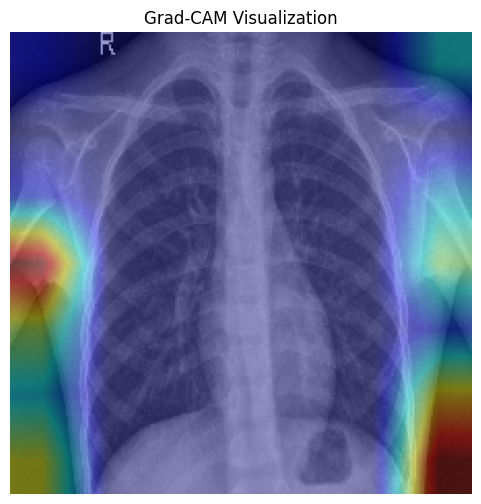

In [38]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = test_gen.filepaths[0]

img = load_img(img_path, target_size=(224,224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="top_conv"
)

heatmap = cv2.resize(heatmap, (224,224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


Grad-CAM görselleştirmeleri, modelin karar verirken ağırlıklı olarak akciğer bölgelerine odaklandığını göstermektedir. Bu durum, modelin klinik olarak anlamlı özellikleri kullandığını ve kararlarının yorumlanabilir olduğunu ortaya koymaktadır.

In [48]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # sigmoid output

    grads = tape.gradient(loss, conv_outputs)

    if grads is None:
        return None

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)

    if max_val == 0:
        return None

    heatmap /= max_val
    return heatmap.numpy()



In [41]:
import gradio as gr
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array


In [49]:
def predict_with_gradcam(img):
    try:
        # 1. Resize & preprocess
        img_resized = img.resize((224,224))
        img_array = img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # 2. Prediction
        prob = model.predict(img_array, verbose=0)[0][0]
        label = "PNEUMONIA" if prob > 0.5 else "NORMAL"
        confidence = prob if prob > 0.5 else 1 - prob

        # 3. Grad-CAM
        heatmap = make_gradcam_heatmap(
            img_array,
            model,
            last_conv_layer_name="block7a_project_conv"
        )

        # Güvenlik: heatmap boşsa
        if heatmap is None or np.max(heatmap) == 0:
            raise ValueError("Grad-CAM heatmap empty")

        heatmap = cv2.resize(heatmap, (224,224))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 4. Overlay (RGB güvenli)
        original = np.array(img_resized).astype(np.uint8)
        heatmap = heatmap.astype(np.uint8)

        superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)
        gradcam_image = Image.fromarray(superimposed)

        return (
            f"{label} (%{confidence*100:.2f})",
            gradcam_image
        )

    except Exception as e:
        # 🔥 Gradio'nun "Hata" demesini engeller
        return (
            f"Hata oluştu: {str(e)}",
            None
        )


In [57]:
interface = gr.Interface(
    fn=predict_with_gradcam,
    inputs=gr.Image(type="pil", label="Upload Chest X-ray"),
    outputs=[
        gr.Text(label="Prediction"),
        gr.Image(type="pil", label="Grad-CAM Visualization")
    ],
    title="Pneumonia Detection with Grad-CAM",
    description="Educational purpose only. Grad-CAM highlights regions used by the model."
)


In [58]:
interface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://edfef52489736fd95e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://edfef52489736fd95e.gradio.live
